In [1]:
using Catalyst
using Test
using DelaySSAToolkit,BenchmarkTools

In [2]:
rn = @reaction_network begin
    ρ, S+I --> E+I
    1/I, I --> R
    r, I --> R
end ρ r
jumpsys = convert(JumpSystem, rn, combinatoric_ratelaws=false)

Model ##ReactionSystem#257 with 3 equations
States (4):
  S(t)
  I(t)
  E(t)
  R(t)
Parameters (2):
  ρ
  r

In [3]:
u0 = [999,1,0,0] # S, I, E, R
tf = 400.
tspan = (0,tf)
ps = [1e-4, 1e-2] # parameters for ρ, r
τ = 20.
dprob = DiscreteProblem(jumpsys,u0,tspan,ps)

DiscreteProblem with uType Vector{Int64} and tType Float64. In-place: true
timespan: (0.0, 400.0)
u0: 4-element Vector{Int64}:
 999
   1
   0
   0

In [5]:
delay_trigger_affect! = function (integrator, rng)
    append!(integrator.de_chan[1], τ)
end
delay_trigger = Dict(1=>delay_trigger_affect!)
delay_interrupt = Dict()
delay_complete = Dict(1=>[2=>1, 3=>-1])
de_chan0 = [[]]
delayjumpset = DelayJumpSet(delay_trigger, delay_complete, delay_interrupt)

DelayJumpSet(Dict{Int64, Any}(1 => var"#11#12"()), Dict{Int64, Any}(1 => [2 => 1, 3 => -1]), Dict{Int64, Any}(), [1], Int64[])

In [8]:
medianlist=[]
algo_list = [DelayDirect(),DelayRejection(),DelayMNRM(),DelayDirectCR()]
for algo in algo_list
    djprob = DelayJumpProblem(jumpsys,dprob,algo,delayjumpset, de_chan0, save_positions=(false,false))
    a=@benchmark solve(djprob, SSAStepper())
    push!(medianlist,copy(median(a).time/1e9))
end
medianlist

4-element Vector{Any}:
 2.04e-5
 5.02e-5
 0.0020741
 7.68e-5

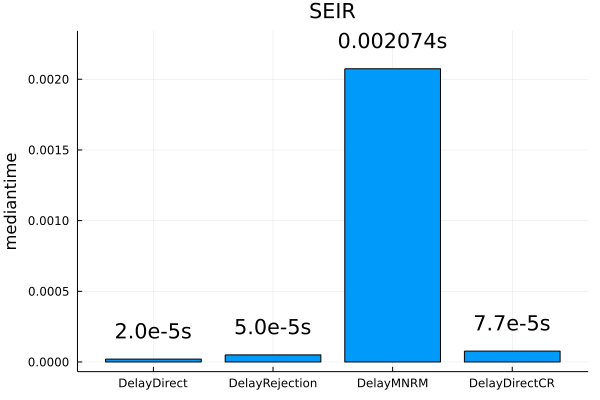

In [12]:
using Plots
medianvalue=[string(round(mt,digits=6),"s") for mt in medianlist]
algo_name = ["DelayDirect","DelayRejection","DelayMNRM","DelayDirectCR"]
bar(algo_name,medianlist,legend=:false,title="SEIR",ylabel="mediantime")
scatter!(algo_name, 0.0002 .+ medianlist , markeralpha=0, series_annotations=medianvalue)